In [1]:
import numpy as np
from datetime import datetime

import torch
import torchvision

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision.utils import save_image

In [2]:
batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# class Encoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(x_size, h_size)
#         self.mu_gen = nn.Linear(h_size, z_size)
#         # make the output to be the logarithm 
#         # i.e will have to take the exponent
#         # which forces variance to be positive
#         # not that this is the diagonal of the covariance
#         self.log_var_gen = nn.Linear(h_size, z_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         mu = self.mu_gen(x)
#         log_var = self.log_var_gen(x)
#         return mu, log_var
    
class Encoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim=10):

        super(Encoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        cnn_kwargs = dict(stride=2, padding=1)

        self.conv1 = nn.Conv2d(n_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.lin1 = nn.Linear(np.product(self.reshape), hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)

        self.mu_logvar_gen = nn.Linear(hidden_dim, self.latent_dim * 2)

    def forward(self, x):
        batch_size = x.size(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.conv_64(x))

        x = x.view((batch_size, -1))
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))

        mu_logvar = self.mu_logvar_gen(x)

        mu, logvar = mu_logvar.view(-1, self.latent_dim, 2).unbind(-1)

        return mu, logvar

In [5]:
# class Decoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_size, h_size)
#         self.fc3 = nn.Linear(h_size, x_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc3(x))
#         # black and white MNIST => sigmoid for each pixel
#         x = torch.sigmoid(x) 
#         return x
    
class Decoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim):

        super(Decoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.img_size = img_size
        self.latent_dim = latent_dim

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, np.product(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)

        if self.img_size[1] == self.img_size[2] == 64:
            self.convT_64 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.convT1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(hidden_channels, n_channels, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)

        x = torch.relu(self.lin1(z))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))

        x = x.view(batch_size, *self.reshape)

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.convT_64(x))

        x = torch.relu(self.convT1(x))
        x = torch.relu(self.convT2(x))

        x = torch.sigmoid(self.convT3(x))

        return x

In [6]:
# class VAE(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(VAE, self).__init__()
#         self.x_size = x_size
#         self.z_size = z_size
#         self.encoder = Encoder(x_size, h_size, z_size)
#         self.decoder = Decoder(x_size, h_size, z_size)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var) # square root in exponent => std
#         eps = torch.randn_like(std)
#         z = std * eps + mu
#         return z

#     def forward(self, x):
#         # make image linear (i.e vector form)
#         x = x.view(-1, self.x_size)
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         x_hat = self.decoder(z)
#         return x_hat, mu, log_var

class VAE(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(VAE, self).__init__()
        if list(img_size[1:]) not in [[32,32], [64,64]]:
            raise RuntimeError("{} sized images not supported. Only (None, 32, 32) and (None, 64, 64) supported. Build your own architecture or reshape images!".format(img_size))

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_pixels = self.img_size[1] * self.img_size[2]
        self.encoder = Encoder(img_size, self.latent_dim)
        self.decoder = Decoder(img_size, self.latent_dim)

        self.reset_parameters()

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + std * eps

        else:
            return mean


    def forward(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        reconstruct = self.decoder(latent_sample)
        return reconstruct, latent_distribution, latent_sample

    def reset_parameters(self):
        self.apply(weights_init)

    def sample_latent(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        return latent_sample

In [7]:
def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation

    mapper = {nn.LeakyReLU: "leaky_relu", nn.ReLU: "relu", nn.Tanh: "tanh",
              nn.Sigmoid: "sigmoid", nn.Softmax: "sigmoid"}
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k

    raise ValueError("Unkown given activation type : {}".format(activation))


def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1

    activation_name = get_activation_name(activation)

    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = nn.init.calculate_gain(activation_name, param)

    return gain
def linear_init(layer, activation="relu"):
    """Initialize a linear layer.
    Args:
        layer (nn.Linear): parameters to initialize.
        activation (`torch.nn.modules.activation` or str, optional) activation that
            will be used on the `layer`.
    """
    x = layer.weight

    if activation is None:
        return nn.init.xavier_uniform_(x)

    activation_name = get_activation_name(activation)

    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return nn.init.kaiming_uniform_(x, a=a, nonlinearity='leaky_relu')
    elif activation_name == "relu":
        return nn.init.kaiming_uniform_(x, nonlinearity='relu')
    elif activation_name in ["sigmoid", "tanh"]:
        return nn.init.xavier_uniform_(x, gain=get_gain(activation))
def weights_init(module):
    if isinstance(module, nn.modules.conv._ConvNd):
        # TO-DO: check litterature
        linear_init(module)
    elif isinstance(module, nn.Linear):
        linear_init(module)

In [8]:
def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

def _kl_normal_loss(mean, logvar):
    latent_dim = mean.size(1)
    latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
    total_kl = latent_kl.sum()

    return total_kl

def _reconstruction_loss(data, recon_data, distribution="bernoulli"):
    batch_size, n_channels, height, width = recon_data.size()
    is_colored = n_channels == 3

    if distribution == "bernoulli":
        loss = F.binary_cross_entropy(recon_data, data, reduction="sum")

    elif distribution == "gaussian":
        loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255

    elif distribution == "laplace":
        loss = F.l1_loss(recon_data, data, reduction="sum")
        loss = loss * 3
        loss = loss * (loss != 0)

    loss = loss / batch_size

    return loss

def loss_function(x_hat, x, mu, log_var, is_train, n_train_steps, steps_anneal=0, beta=1, C_init=0., C_fin=20., gamma=100.):
    """Compute the ELBO loss"""
    x_size = x_hat.size(-1)
    # black or white image => use sigmoid for each pixel
#     rec_loss = F.binary_cross_entropy(x_hat, x.view(-1, x_size), reduction='sum')
    rec_loss = _reconstruction_loss(x, x_hat, distribution="bernoulli")
    # closed form solution for gaussian prior and posterior
#     kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_div = _kl_normal_loss(mu, log_var)
    
    C = (linear_annealing(C_init, C_fin, n_train_steps, steps_anneal) if is_train else C_fin)
    vae_loss = rec_loss + gamma * (kl_div - C).abs()
#     vae_loss = rec_loss + beta * kl_div
    return vae_loss

In [9]:
class Trainer:
    def __init__(self, model, optimizer=optim.Adam, loss_function=loss_function):
        self.model = model 
        self.optimizer = optimizer(self.model.parameters())
        self.loss_function = loss_function
        self.epoch = 0
        
    def __call__(self, train, test, n_epochs=100):
        self.epoch = 0
        for _ in range(n_epochs):
            self._train_epoch(train)
            self._test_epoch(test)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           '../results/sample_' + str(self.epoch) + '.png')
        
    def _train_epoch(self, train):
        self.epoch += 1
        model.train() # make sure train mode (e.g. dropout)
        train_loss = 0
        for i, (x, _) in enumerate(train):
            x = x.to(device) # data on GPU 
            self.optimizer.zero_grad() # reset all previous gradients
            x_hat, latent_distribution, latent_sample = model(x)
            loss = self.loss_function(x_hat, x, *latent_distribution, True, i)
            loss.backward() # backpropagate (i.e store gradients)
            train_loss += loss.item() # compute loss (.item because only the value)
            self.optimizer.step() # take optimizing step (~gradient descent)

        print('Epoch: {} Train loss: {:.4f}'.format(
              self.epoch, train_loss / len(train.dataset)))
        
    def _test_epoch(self, test):
        model.eval() # make sure evaluate mode (e.g. dropout)
        test_loss = 0
        with torch.no_grad():  # stop gradients computation
            for i, (x, _) in enumerate(test):
                x = x.to(device)
                x_hat, latent_distribution, latent_sample = model(x)
                test_loss += loss_function(x_hat, x, *latent_distribution, False, i).item()

        print('Test loss: {:.4f}'.format(test_loss/len(test.dataset)))


In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

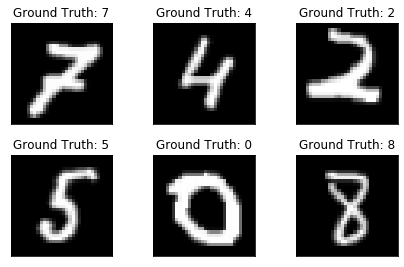

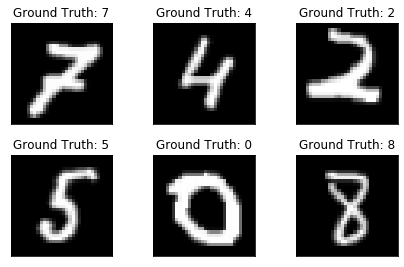

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [12]:
list(example_data[0].shape)

[1, 32, 32]

In [13]:
img_size = list(example_data[0].shape) # mnist image
# h_size = 256
z_size = 12
model = VAE(img_size, z_size).to(device) # migrates to CUDA if you can

In [14]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (mu_logvar_gen): Linear(in_features=256, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [15]:
# trainer = Trainer(model)

In [16]:
# %%time
# trainer(train_loader, test_loader)

In [17]:
# torch.save(model.state_dict(), './model/betaVAE.pt')

In [18]:
# older model
# model.load_state_dict(torch.load('./model/betaVAE.pt'))

In [19]:
class SiameseDiscriminator(nn.Module):
    def __init__(self, image_size):
        super(SiameseDiscriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),

            nn.Conv2d(4, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.Conv2d(8, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8 * 26 * 26, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 15)
        )
    
    def forward_once(self, x):
        """Define the computation performed at every call by one side of siamese network."""
#         x = x_.unsqueeze(0)
#         print(x.shape)
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        """Define the computation performed at every call."""
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [20]:
class SiameseLoss(nn.Module):
    def __init__(self, margin):
        super(Loss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)
    
    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [21]:
class DistanceBasedLoss(nn.Module):
    """
    Distance based loss function.
    For reference see:
    Hadsell et al., CVPR'06
    Chopra et al., CVPR'05
    Vo and Hays, ECCV'16
    """

    def __init__(self, margin):
        """Set parameters of distance-based loss function."""
        super(DistanceBasedLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [22]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin):
        """Set parameters of contrastive loss function."""
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        clamped = torch.clamp(self.margin - euclidean_distance, min=0.0)
        similar_loss = (1 - label) * 0.5 * torch.pow(euclidean_distance, 2)
        dissimilar_loss = label * 0.5 * torch.pow(clamped, 2)
        contrastive_loss = similar_loss + dissimilar_loss

        return torch.mean(contrastive_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [23]:
from math import exp


def gaussian(window_size, sigma):
    """Compute gaussian window, that is a tensor with values of the bell curve."""
    gauss = torch.Tensor(
        [exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel):
    """Generate a two dimensional window with desired number of channels."""
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    """Compute the structural similarity index between two images."""
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1) *
                                                    (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(nn.Module):
    """Wrapper class used to compute the structural similarity index."""

    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        """Execute the computation of the structural similarity index."""
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

In [24]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler


class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return torch.FloatTensor([target]), img1, img2

    def __len__(self):
        return len(self.mnist_dataset)

In [25]:
mnist_siamese_dataset = SiameseMNIST(mnist_dataset)
mnist_siamese_dataset_test = SiameseMNIST(mnist_dataset_test)

In [26]:
class Config:
    def __init__(self, image_size=32, mode='train', model_path='./model/Siamese', 
                 generate_path='./Generated', num_epochs=100, distance_weight=1.0, 
                 dataset='MNIST', tensorboard=True, generator=model, batch_size=64, batch_size_test=1000):
        self.mode = mode
        self.image_size = image_size
        self.model_path = model_path
        self.generate_path = generate_path
        self.dataset = dataset
        self.num_epochs = num_epochs
        self.distance_weight = distance_weight
        self.tensorboard = tensorboard
        self.generator = generator
        self.batch_size = batch_size
        self.batch_size_test = batch_size_test

In [27]:
from tqdm import tqdm
class SiameseGanSolver(object):
    """Solving GAN-like neural network with siamese discriminator."""

    def __init__(self, config, data_loader):
        """Set parameters of neural network and its training."""
        self.ssim_loss = SSIM()
        self.generator = config.generator
        self.discriminator = None
        self.distance_based_loss = None

        self.g_optimizer = None
        self.d_optimizer = None

        self.g_conv_dim = 128

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 0.0001
        self.image_size = config.image_size
        self.num_epochs = config.num_epochs
        self.distance_weight = config.distance_weight

        self.data_loader = data_loader
#         print(self.data_loader.dataset)
        self.generate_path = config.generate_path
        self.model_path = config.model_path
        self.tensorboard = config.tensorboard

        if self.tensorboard:
            self.tb_writer = tensorboardX.SummaryWriter(
                filename_suffix='_%s_%s' % (config.distance_weight, config.dataset))
            self.tb_graph_added = False

        self.build_model()

    def build_model(self):
        """Build generator and discriminator."""
#         self.generator = Generator(self.g_conv_dim, noise=self.noise, residual=self.residual)
        self.discriminator = SiameseDiscriminator(self.image_size)
        self.distance_based_loss = DistanceBasedLoss(2.0)

        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(), self.learning_rate, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), self.learning_rate, [self.beta1, self.beta2])

        if torch.cuda.is_available():
            self.generator.cuda()
            self.discriminator.cuda()
            self.distance_based_loss.cuda()

    def train(self):
        """Train generator and discriminator in minimax game."""
        # Prepare tensorboard writer
        if self.tensorboard:
            step = 0
        
        print("We are training\n")

        for epoch in tqdm(range(self.num_epochs)):
            print(str(epoch) + " " + str(datetime.now()))
#             i = 0
            for label, images0, images1 in self.data_loader:
#                 i += 1
#                 print(i)
                images0 = to_variable(images0)
                images1 = to_variable(images1)
#                 print("label:", label)
                label = to_variable(label)
#                 print("We extracted samples")
                # Train discriminator to recognize identity of real images
                output0, output1 = self.discriminator(images0, images1)
                d_real_loss = self.distance_based_loss(output0, output1, label)
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                d_real_loss.backward()
                self.d_optimizer.step()
#                 print("We did backprop")
                # Train discriminator to recognize identity of fake(privatized) images
                
                privatized_imgs, _, _ = self.generator(images0)
#                 print(privatized_imgs)
                output0, output1 = self.discriminator(images0, privatized_imgs)

                # Discriminator wants to minimize Euclidean distance between
                # original & privatized versions, hence label = 0
                d_fake_loss = self.distance_based_loss(output0, output1, 0)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                d_fake_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                d_fake_loss.backward()
                self.d_optimizer.step()

                # Train generator to fool discriminator
                # Generator wants to push the distance between original & privatized
                # right to the margin, hence label = 1
                privatized_imgs, _, _ = self.generator(images0)
                output0, output1 = self.discriminator(images0, privatized_imgs)
                g_loss = self.distance_based_loss(output0, output1, 1)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                g_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()

                # Write losses to tensorboard
                if self.tensorboard:
                    self.tb_writer.add_scalar('phase0/discriminator_real_loss',
                                              d_real_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/discriminator_fake_loss',
                                              d_fake_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/generator_loss',
                                              g_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/distance_loss',
                                              distance.item(), step)

                    step += 1

            # Monitor training after each epoch
            if self.tensorboard:
                self._monitor_phase_0(self.tb_writer, step)

            # At the end save generator and discriminator to files
            if (epoch + 1) % 10 == 0:
                g_path = os.path.join(self.model_path, 'G', 'G-%d.pt' % (epoch+1))
                torch.save(self.generator.state_dict(), g_path)
                d_path = os.path.join(self.model_path, 'D', 'D-%d.pt' % (epoch+1))
                torch.save(self.discriminator.state_dict(), d_path)

        if self.tensorboard:
            self.tb_writer.close()

    def _monitor_phase_0(self, writer, step, n_images=10):
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions == label)

            if total_pairs > 1000:
                break

        # Write accuracy to tensorboard
        accuracy = correct_pairs / total_pairs
        writer.add_scalar('phase0/discriminator_accuracy', accuracy, step)

        # Generate previews of privatized images
        reals, fakes = [], []
        for _, image, _ in self.data_loader.dataset:
#             print("i: ", image.shape)
            g_image, _, _ = self.generator(to_variable(image).unsqueeze(0))
            g_image = g_image.squeeze(0)
#             print("g: ", g_image.shape)
            reals.append(denorm(to_variable(image).data[0]))
            fakes.append(denorm(to_variable(g_image).data[0]))
            if len(reals) == n_images:
                break

        # Write images to tensorboard
        real_previews = torchvision.utils.make_grid(reals, nrow=n_images)
        fake_previews = torchvision.utils.make_grid(fakes, nrow=n_images)
#         print(real_previews.shape)
#         print(fake_previews.shape)
#         img = torchvision.utils.make_grid([real_previews, fake_previews], nrow=1)
        img = torchvision.utils.make_grid(torch.stack(
            [*real_previews.unsqueeze_(1).unbind(0), *fake_previews.unsqueeze_(1).unbind(0)]), nrow=1)
        writer.add_image('Previews', img, step)

    def generate(self):
        """Generate privatized images."""
        # Load trained parameters (generator)
        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        # Generate the images
        for relative_path, image in self.data_loader:
            fake_image, _, _ = self.generator(to_variable(image))
            fake_path = os.path.join(self.generate_path, relative_path[0])
            if not os.path.exists(os.path.dirname(fake_path)):
                os.makedirs(os.path.dirname(fake_path))
            torchvision.utils.save_image(fake_image.data, fake_path, nrow=1)

    def check_discriminator_accuracy(self):
        """Measure discriminator's accuracy."""
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        d_path = os.path.join(self.model_path, 'D', 'D-%d.pkl' % self.num_epochs)
        self.discriminator.load_state_dict(torch.load(d_path))
        self.discriminator.eval()

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions)

        accuracy = correct_pairs / total_pairs
        print('distance weight = %f' % self.distance_weight)
        print('accuracy = %f' % accuracy)
        
def to_variable(tensor):
    """Convert tensor to variable."""
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

def denorm(image):
    """Convert image range (-1, 1) to (0, 1)."""
    out = (image + 1) / 2
    return out.clamp(0, 1)

In [28]:
from datetime import datetime, time
import tensorboardX, math, os
from torch.utils.data import DataLoader
config = Config(num_epochs=200, tensorboard=True)
siamese_data_loader = DataLoader(dataset=mnist_siamese_dataset, batch_size=config.batch_size, shuffle=True)
siamese_data_loader_test = DataLoader(dataset=mnist_siamese_dataset_test, batch_size=config.batch_size_test, shuffle=True)
solver = SiameseGanSolver(config, siamese_data_loader)
start_time = datetime.now()

In [ ]:
# %%time
solver.train()

  0%|          | 0/200 [00:00<?, ?it/s]

We are training

0 2020-01-09 17:28:57.412784


  0%|          | 1/200 [00:35<1:58:35, 35.76s/it]

1 2020-01-09 17:29:33.174764


  1%|          | 2/200 [01:10<1:56:42, 35.36s/it]

2 2020-01-09 17:30:07.619861


  2%|▏         | 3/200 [01:45<1:55:46, 35.26s/it]

3 2020-01-09 17:30:42.647194


In [ ]:
from mail import send_mail
end_time = datetime.now()
print(send_mail(start_time, end_time))